# EDA: Dataset Reseñas en Español

## Objetivos
1. **Cargar y explorar** estructura del CSV
2. **Visualizar** distribuciones de ratings y categorías
3. **Analizar reviews ambiguas** (stars == 3)
4. **Prototipar NLP español**: limpieza de texto específica

## Características del Dataset
- **Idioma**: Español
- **Formato**: CSV
- **SIN campo de fecha**: No es posible análisis temporal

---

In [1]:
# Setup e imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# === DETECCION ROBUSTA DEL PROJECT ROOT ===
def find_project_root() -> Path:
    """Busca la raiz del proyecto (donde esta pyproject.toml)."""
    notebook_dir = Path.cwd()
    for parent in [notebook_dir] + list(notebook_dir.parents):
        if (parent / "pyproject.toml").exists():
            return parent
    if notebook_dir.name == "notebooks":
        return notebook_dir.parent
    return notebook_dir

project_root = find_project_root()
sys.path.insert(0, str(project_root / "src"))

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette('husl')

from tfm.config.settings import get_settings, BRONZE_FILES, PROJECT_ROOT
from tfm.tools.nlp_utils import (
    clean_text_spanish, compute_sentiment_baseline, 
    extract_text_features, analyze_star_distribution
)

settings = get_settings()
print(f"Project root: {PROJECT_ROOT}")
print(f"ES Bronze dir: {settings.es_bronze_dir}")
print(f"Es ruta absoluta: {settings.es_bronze_dir.is_absolute()}")

# Verificar archivo
es_file = settings.es_bronze_dir / BRONZE_FILES['es']['reviews']
print(f"\nArchivo: {es_file}")
print(f"Existe: {es_file.exists()}")

Project root: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents
ES Bronze dir: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\data\bronze\rese_esp
Es ruta absoluta: True

Archivo: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\data\bronze\rese_esp\reviews_dataframe_completo.csv
Existe: True


## 1. Carga de Datos

In [2]:
# Cargar dataset español
es_path = settings.es_bronze_dir / BRONZE_FILES['es']['reviews']
print(f"Cargando: {es_path}")

# Intentar cargar con diferentes encodings
try:
    df_es = pl.read_csv(es_path)
except:
    try:
        df_es = pl.read_csv(es_path, encoding='latin1')
    except:
        df_es = pl.read_csv(es_path, encoding='utf-8', ignore_errors=True)

print(f"\nRegistros cargados: {df_es.height:,}")
print(f"Columnas: {df_es.columns}")
print(f"\nTipos de datos:")
for col, dtype in zip(df_es.columns, df_es.dtypes):
    print(f"  {col}: {dtype}")

df_es.head(3)

Cargando: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\data\bronze\rese_esp\reviews_dataframe_completo.csv

Registros cargados: 210,000
Columnas: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category']

Tipos de datos:
  review_id: String
  product_id: String
  reviewer_id: String
  stars: Int64
  review_body: String
  review_title: String
  language: String
  product_category: String


review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""es_0491108""","""product_es_0296024""","""reviewer_es_0999081""",1,"""Nada bueno se me fue ka pantal…","""television Nevir""","""es""","""electronics"""
"""es_0869872""","""product_es_0922286""","""reviewer_es_0216771""",1,"""Horrible, nos tuvimos que comp…","""Dinero tirado a la basura con …","""es""","""electronics"""
"""es_0811721""","""product_es_0474543""","""reviewer_es_0929213""",1,"""Te obligan a comprar dos unida…","""solo llega una unidad cuando t…","""es""","""drugstore"""


In [3]:
# Identificar columnas relevantes
# Buscar columna de rating (puede llamarse 'stars', 'rating', 'score', etc.)
rating_col = None
text_col = None
category_col = None

for col in df_es.columns:
    col_lower = col.lower()
    if 'star' in col_lower or 'rating' in col_lower or 'score' in col_lower:
        rating_col = col
    if 'body' in col_lower or 'text' in col_lower or 'review' in col_lower:
        if 'title' not in col_lower:
            text_col = col
    if 'categ' in col_lower:
        category_col = col

print(f"Columna de rating detectada: {rating_col}")
print(f"Columna de texto detectada: {text_col}")
print(f"Columna de categoría detectada: {category_col}")

# Mostrar valores únicos del rating para entender la escala
if rating_col:
    print(f"\nValores únicos de rating: {df_es[rating_col].unique().sort().to_list()}")

Columna de rating detectada: stars
Columna de texto detectada: review_body
Columna de categoría detectada: product_category

Valores únicos de rating: [1, 2, 3, 4, 5]


## 2. Análisis de Distribuciones

In [4]:
# Renombrar columnas para consistencia (ajustar según nombres reales)
# Este código es adaptativo - ajusta los nombres según lo que encuentre

column_mapping = {}
for col in df_es.columns:
    col_lower = col.lower()
    if 'star' in col_lower:
        column_mapping[col] = 'stars'
    elif 'rating' in col_lower or 'score' in col_lower:
        column_mapping[col] = 'stars'
    elif col_lower == 'review_body' or ('body' in col_lower and 'review' in col_lower):
        column_mapping[col] = 'text'
    elif 'product_category' in col_lower or col_lower == 'category':
        column_mapping[col] = 'category'

if column_mapping:
    df_es = df_es.rename(column_mapping)
    print(f"Columnas renombradas: {column_mapping}")

print(f"Columnas actuales: {df_es.columns}")

Columnas renombradas: {'stars': 'stars', 'review_body': 'text', 'product_category': 'category'}
Columnas actuales: ['review_id', 'product_id', 'reviewer_id', 'stars', 'text', 'review_title', 'language', 'category']


Distribución de Stars:
shape: (5, 3)
┌───────┬───────┬────────────┐
│ stars ┆ count ┆ percentage │
│ ---   ┆ ---   ┆ ---        │
│ i64   ┆ u32   ┆ f64        │
╞═══════╪═══════╪════════════╡
│ 1     ┆ 42000 ┆ 20.0       │
│ 2     ┆ 42000 ┆ 20.0       │
│ 3     ┆ 42000 ┆ 20.0       │
│ 4     ┆ 42000 ┆ 20.0       │
│ 5     ┆ 42000 ┆ 20.0       │
└───────┴───────┴────────────┘

RESUMEN:
  Positivas (4-5): 40.0%
  Negativas (1-2): 40.0%
  Ambiguas (3):    20.0%


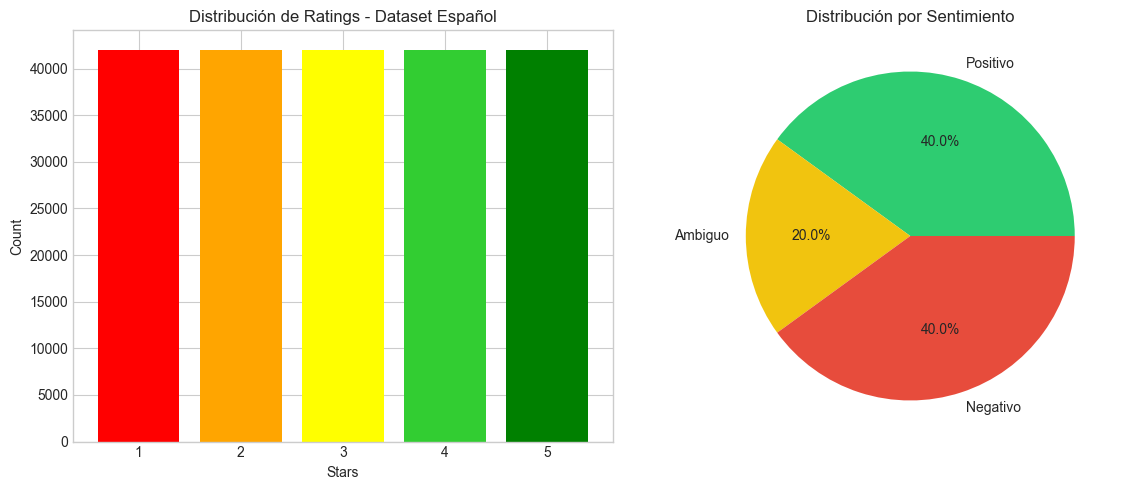

In [6]:
# Distribución de ratings
if 'stars' in df_es.columns:
    stars_dist = df_es.group_by('stars').agg(pl.count().alias('count')).sort('stars')
    total = stars_dist['count'].sum()
    stars_dist = stars_dist.with_columns((pl.col('count') / total * 100).round(2).alias('percentage'))
    
    print("Distribución de Stars:")
    print(stars_dist)
    
    # Calcular agregados
    pct_positive = stars_dist.filter(pl.col('stars') >= 4)['percentage'].sum()
    pct_negative = stars_dist.filter(pl.col('stars') <= 2)['percentage'].sum()
    pct_ambiguous = stars_dist.filter(pl.col('stars') == 3)['percentage'].sum()
    
    print(f"\nRESUMEN:")
    print(f"  Positivas (4-5): {pct_positive:.1f}%")
    print(f"  Negativas (1-2): {pct_negative:.1f}%")
    print(f"  Ambiguas (3):    {pct_ambiguous:.1f}%")
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    colors = ['red', 'orange', 'yellow', 'limegreen', 'green']
    stars_pd = stars_dist.to_pandas()
    axes[0].bar(stars_pd['stars'], stars_pd['count'], color=colors)
    axes[0].set_xlabel('Stars')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Distribución de Ratings - Dataset Español')
    
    sentiment_data = [pct_positive, pct_ambiguous, pct_negative]
    axes[1].pie(sentiment_data, labels=['Positivo', 'Ambiguo', 'Negativo'], 
                colors=['#2ecc71', '#f1c40f', '#e74c3c'], autopct='%1.1f%%')
    axes[1].set_title('Distribución por Sentimiento')
    plt.tight_layout()
    plt.show()
else:
    print("No se encontró columna de rating")

## 3. Análisis de Texto

Estadísticas de Texto:
shape: (1, 5)
┌────────────┬───────────────┬───────────┬───────┬────────────┐
│ avg_length ┆ median_length ┆ avg_words ┆ empty ┆ very_short │
│ ---        ┆ ---           ┆ ---       ┆ ---   ┆ ---        │
│ f64        ┆ f64           ┆ f64       ┆ u32   ┆ u32        │
╞════════════╪═══════════════╪═══════════╪═══════╪════════════╡
│ 151.292    ┆ 120.0         ┆ 27.795571 ┆ 0     ┆ 0          │
└────────────┴───────────────┴───────────┴───────┴────────────┘


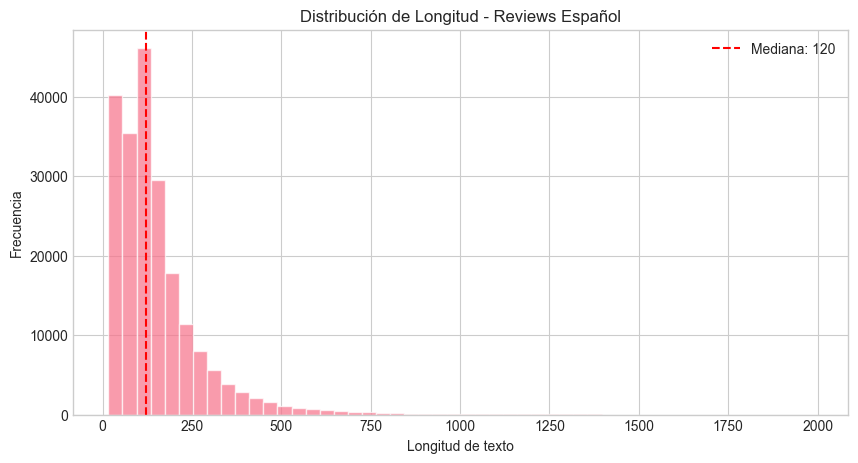

In [7]:
# Análisis de texto - buscar la columna correcta
text_col = None
for col in df_es.columns:
    if 'text' in col.lower() or 'body' in col.lower():
        text_col = col
        break

if text_col:
    # Añadir métricas de texto
    df_es = df_es.with_columns([
        pl.col(text_col).str.len_chars().alias('text_length'),
        pl.col(text_col).str.split(' ').list.len().alias('word_count'),
    ])
    
    if 'stars' in df_es.columns:
        df_es = df_es.with_columns((pl.col('stars') == 3).alias('is_ambiguous'))
    
    # Estadísticas
    text_stats = df_es.select([
        pl.col('text_length').mean().alias('avg_length'),
        pl.col('text_length').median().alias('median_length'),
        pl.col('word_count').mean().alias('avg_words'),
        (pl.col('text_length') == 0).sum().alias('empty'),
        (pl.col('text_length') < 10).sum().alias('very_short'),
    ])
    print("Estadísticas de Texto:")
    print(text_stats)
    
    # Visualización
    fig, ax = plt.subplots(figsize=(10, 5))
    lengths = df_es.filter(pl.col('text_length') < 2000)['text_length'].to_numpy()
    ax.hist(lengths, bins=50, edgecolor='white', alpha=0.7)
    ax.axvline(np.median(lengths), color='red', linestyle='--', label=f'Mediana: {np.median(lengths):.0f}')
    ax.set_xlabel('Longitud de texto')
    ax.set_ylabel('Frecuencia')
    ax.set_title('Distribución de Longitud - Reviews Español')
    ax.legend()
    plt.show()
else:
    print("No se encontró columna de texto")

## 4. Análisis de Categorías

Total categorías únicas: 30

Top 15 Categorías:
shape: (15, 2)
┌──────────────┬───────┐
│ category     ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ home         ┆ 28328 │
│ wireless     ┆ 27208 │
│ toy          ┆ 14328 │
│ sports       ┆ 13856 │
│ pc           ┆ 11720 │
│ …            ┆ …     │
│ apparel      ┆ 6014  │
│ drugstore    ┆ 5778  │
│ book         ┆ 5528  │
│ furniture    ┆ 5481  │
│ baby_product ┆ 5098  │
└──────────────┴───────┘


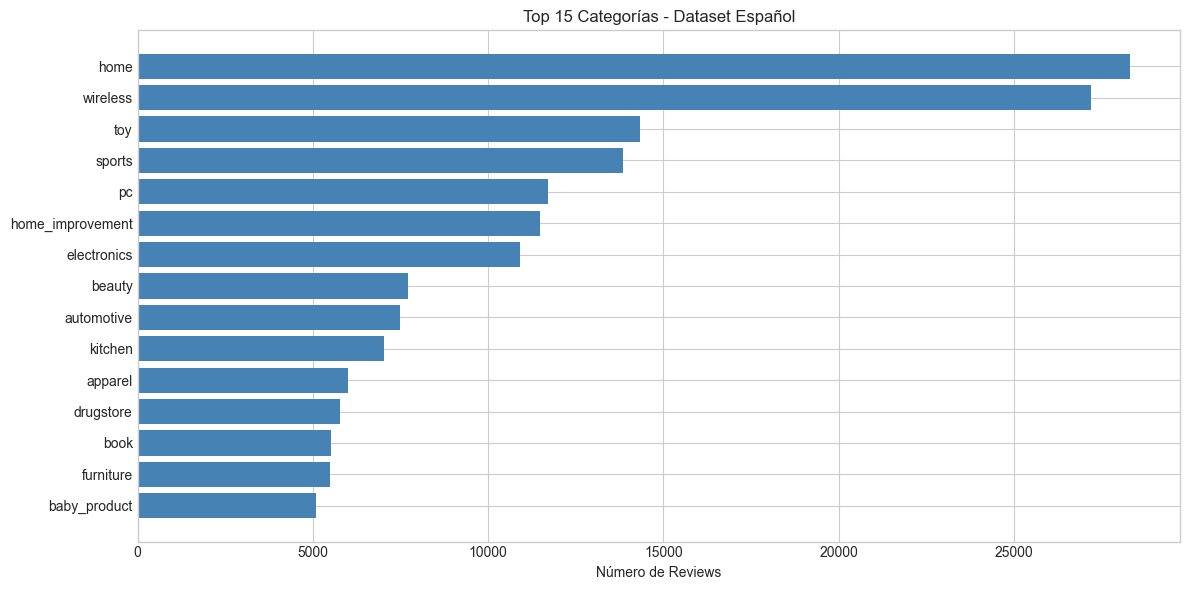

In [8]:
# Análisis de categorías
cat_col = None
for col in df_es.columns:
    if 'categ' in col.lower():
        cat_col = col
        break

if cat_col:
    category_counts = df_es.group_by(cat_col).agg(pl.count().alias('count')).sort('count', descending=True)
    print(f"Total categorías únicas: {len(category_counts)}")
    print("\nTop 15 Categorías:")
    print(category_counts.head(15))
    
    # Visualización
    fig, ax = plt.subplots(figsize=(12, 6))
    top_cats = category_counts.head(15).to_pandas()
    ax.barh(top_cats[cat_col], top_cats['count'], color='steelblue')
    ax.set_xlabel('Número de Reviews')
    ax.set_title('Top 15 Categorías - Dataset Español')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No se encontró columna de categoría")

## 5. Prototipo NLP Español

In [9]:
# Probar limpieza de texto español
test_texts_es = [
    "¡Excelente producto! Lo recomiendo mucho",
    "Muy malo, no funciona. Email: test@mail.com",
    "Normal, nada especial. http://ejemplo.com",
]

print("Prueba de limpieza de texto español:")
print("=" * 50)
for text in test_texts_es:
    cleaned = clean_text_spanish(text)
    print(f"Original: {text}")
    print(f"Limpio:   {cleaned}")
    print("-" * 30)

Prueba de limpieza de texto español:
Original: ¡Excelente producto! Lo recomiendo mucho
Limpio:   excelente producto lo recomiendo mucho
------------------------------
Original: Muy malo, no funciona. Email: test@mail.com
Limpio:   muy malo no funciona email
------------------------------
Original: Normal, nada especial. http://ejemplo.com
Limpio:   normal nada especial
------------------------------


In [10]:
# Probar baseline de sentimiento con textos españoles
test_reviews_es = [
    ("¡Excelente producto!", 5),
    ("Bueno pero podría mejorar", 4),
    ("Normal, nada especial", 3),  # AMBIGUO
    ("Decepcionante", 2),
    ("Pésima calidad", 1),
]

print("Baseline Sentiment (español):")
print("=" * 60)
for text, stars in test_reviews_es:
    result = compute_sentiment_baseline(stars)
    print(f"Stars={stars} | {result.label:8} | Score={result.score:+.2f} | Ambiguo={result.is_ambiguous}")
    print(f"   Texto: {text}")

print("\nNOTA: Para español necesitamos un modelo específico (pysentimiento, BETO)")
print("El baseline usa solo las estrellas, no el texto.")

Baseline Sentiment (español):
Stars=5 | positive | Score=+1.00 | Ambiguo=False
   Texto: ¡Excelente producto!
Stars=4 | positive | Score=+0.50 | Ambiguo=False
   Texto: Bueno pero podría mejorar
Stars=3 | neutral  | Score=+0.00 | Ambiguo=True
   Texto: Normal, nada especial
Stars=2 | negative | Score=-0.50 | Ambiguo=False
   Texto: Decepcionante
Stars=1 | negative | Score=-1.00 | Ambiguo=False
   Texto: Pésima calidad

NOTA: Para español necesitamos un modelo específico (pysentimiento, BETO)
El baseline usa solo las estrellas, no el texto.


## 6. Resumen y Hallazgos

In [11]:
print("="*60)
print("RESUMEN DE HALLAZGOS - DATASET ESPAÑOL")
print("="*60)

print(f"""
ESTRUCTURA DE DATOS:
- Total registros: {df_es.height:,}
- Columnas: {len(df_es.columns)}

LIMITACIÓN IMPORTANTE:
- Este dataset NO tiene campo de fecha
- No es posible análisis temporal
- El Router debe rechazar queries temporales

MODELOS NLP PARA ESPAÑOL (Fase 5):
- pysentimiento: Modelo transformer para español
- BETO: BERT entrenado en español
- mBERT: BERT multilingüe
""")

print("\n EDA Dataset Español completado!")

RESUMEN DE HALLAZGOS - DATASET ESPAÑOL

ESTRUCTURA DE DATOS:
- Total registros: 210,000
- Columnas: 11

LIMITACIÓN IMPORTANTE:
- Este dataset NO tiene campo de fecha
- No es posible análisis temporal
- El Router debe rechazar queries temporales

MODELOS NLP PARA ESPAÑOL (Fase 5):
- pysentimiento: Modelo transformer para español
- BETO: BERT entrenado en español
- mBERT: BERT multilingüe


 EDA Dataset Español completado!


## 7. Conclusiones del EDA - Dataset Español

### 7.1 Estructura de Datos

El dataset de reviews en español presenta caracteristicas distintivas:

- **Total registros**: 210,000 reviews de productos
- **Columnas clave**: review_id, product_id, reviewer_id, stars, review_body, review_title, language, product_category
- **Idioma**: Español (confirmado en columna language)
- **Escala de rating**: 1-5 estrellas (estandar)

### 7.2 Hallazgos Clave

**Distribucion de Ratings:**
- Dataset PERFECTAMENTE BALANCEADO: 20% para cada nivel de estrellas (1-5)
- Esto es inusual y sugiere que el dataset fue curado o muestreado intencionalmente
- 40% positivas (4-5), 40% negativas (1-2), 20% ambiguas (3)
- El balance artificial es util para entrenar modelos de clasificacion

**Caracteristicas del Texto:**
- Longitud promedio: 151 caracteres, ~28 palabras
- Reviews mas cortas que las de Yelp (productos vs servicios)
- Mediana de 120 caracteres
- No hay reviews vacias ni extremadamente cortas
- Textos concisos y directos tipicos de reviews de productos

**Categorias de Productos:**
- 30 categorias unicas
- Top categorias: home (28k), wireless (27k), toy (14k), sports (14k)
- Diversidad de productos permite analisis por vertical

**Limitacion Importante:**
- NO hay campo de fecha/timestamp
- Imposible realizar analisis temporal
- El Router del agente debe rechazar queries temporales para este dataset

### 7.3 Implicaciones para el Sistema de Agentes

**Tools necesarios:**
1. `get_es_review_stats`: Estadisticas de reviews por categoria/rating
2. `analyze_product_sentiment`: Sentimiento por producto
3. `category_comparison`: Comparar metricas entre categorias

**Casos de uso del agente:**
- "Cual es la categoria con mejores reviews en español?"
- "Analiza el sentimiento de reviews de productos wireless"
- "Muestrame ejemplos de reviews negativas de juguetes"

**Restricciones del Router:**
- Rechazar consultas temporales ("reviews del ultimo mes")
- Informar al usuario que no hay datos de fecha disponibles
- Redirigir a Yelp u Olist si se requiere analisis temporal

**Preprocesamiento Silver Layer:**
- Limpiar texto con caracteres españoles (ñ, acentos)
- Renombrar columnas a formato estandar
- Calcular metricas de texto
- Flag is_ambiguous para reviews de 3 estrellas
